# Utility Theory

This notebook summarizes basic utility theory and how it can be used in portfolio optimisation.

## Load Packages and Extra Functions

[Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) is an optimization package.

In [1]:
using Printf, Optim

include("src/printmat.jl");

In [2]:
using Plots
default(size = (480,320),fmt = :png)

# Utility Functions

Several of the examples will use the CRRA utility function, which is $U(x) = \frac{x^{1-\gamma}}{1-\gamma}$, where $\gamma$ is the relative risk aversion.

### A Remark on the Code

1. A Julia function can be created in several ways. For a simple one-liner, it is enough to do like this:
`MySum(x,y) = x + y`

2. If the function `U(x,γ)` is written for a scalar `x` value, then we can calculate its value at each element of an array or range `x_range` by using `U.(x_range,γ)`.

In [3]:
"""
    U(x,γ)

CRRA utility function, γ is the risk aversion.
"""
U(x,γ) = x^(1-γ)/(1-γ)



"""
    U_1(u,γ)

Inverse of CRRA utility function. Solves for x st. U(x,γ) = u.
"""
U_1(u,γ) = (u*(1-γ))^(1/(1-γ))

U_1

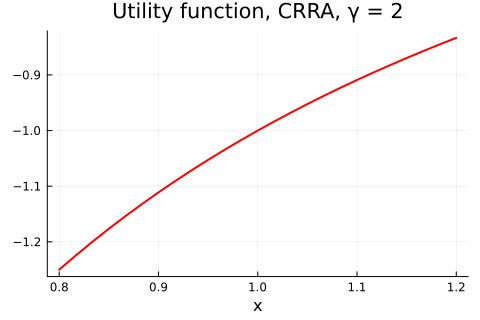

In [4]:
x_range = range(0.8,1.2,length=25)            #possible outcomes
γ = 2

p1 = plot( x_range,U.(x_range,γ),            #notice the dot(.)
           linecolor = :red,
           linewidth = 2,
           legend = false,
           title = "Utility function, CRRA, γ = $γ",
           xlabel = "x" )
display(p1)

# Expected Utility

Recall: if $\pi_s$ is the probability of outcome ("state") $x_s$ and there are $S$ possible outcomes, then the expected value is


$\text{E}x = \sum\nolimits_{s=1}^{S} \pi_{s} x_s$.

Similarly, the expected utility is

$\text{E}U(x) = \sum\nolimits_{s=1}^{S} \pi_{s}U(x_s)$

### A Remark on the Code

When `x` is a vector, then `U.(x,γ)` is a vector of the corresponding utility values. Therefore, `E(π,U.(x,γ))` sums `π[i]*U(x[i],γ)` across all `i`.

In [5]:
"""
    E(π,z)

Calculate the expected value from vector of outcomes `z` and a vector of their probabilities `π`.
"""
E(π,z) = sum(π.*z)           #alternatively, dot(π,z) or π'z

E

In [6]:
γ = 2                   #risk aversion

(x₁,x₂) = (0.85,1.15)             #possible outcomes
(π₁,π₂) = (0.5,0.5)               #probabilities of outcomes

state₁ = [x₁,U(x₁,γ),π₁]          #for printing
state₂ = [x₂,U(x₂,γ),π₂]

printblue("Different states: wealth, utility and probability:\n")
printmat([state₁ state₂];colNames=["state 1","state 2"],rowNames=["wealth","utility","probability"])

Ex      = E([π₁,π₂],[x₁,x₂])         #expected wealth
ExpUtil = E([π₁,π₂],U.([x₁,x₂],γ))   #expected utility

printmat([Ex,ExpUtil];rowNames=["Expected wealth","Expected utility"])

Different states: wealth, utility and probability:

              state 1   state 2
wealth          0.850     1.150
utility        -1.176    -0.870
probability     0.500     0.500

Expected wealth      1.000
Expected utility    -1.023



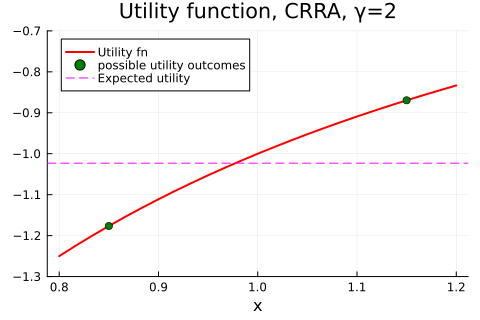

In [7]:
p1 = plot( x_range,U.(x_range,γ),
           linecolor = :red,
           linewidth = 2,
           label = "Utility fn",
           ylim = (-1.3,-0.7),
           legend = :topleft,
           title = "Utility function, CRRA, γ=$γ",
           xlabel = "x" )
scatter!([x₁,x₂],U.([x₁,x₂],γ),markercolor=:green,label="possible utility outcomes")
hline!([ExpUtil],linecolor=:magenta,line=(:dash,1),label="Expected utility")
display(p1)

# Certainty Equivalent

The certainty equivalent (here denoted $P$) is the sure value that solves 

$U(P) = \text{E}U(x)$,

where the right hand side is the expected utility from the random $x$. $P$ is thus the highest price the investor is willing to pay for "asset" $x$.

The code below solves for $P$ by inverting the utility function, first for the same risk aversion ($\gamma$) as above, and later for different values of $\gamma$.

We can think of $\textrm{E}(x)/P-1$ as the expected return on $x$ that the investor requires in order to buy the asset. It is increasing in the risk aversion $\gamma$.

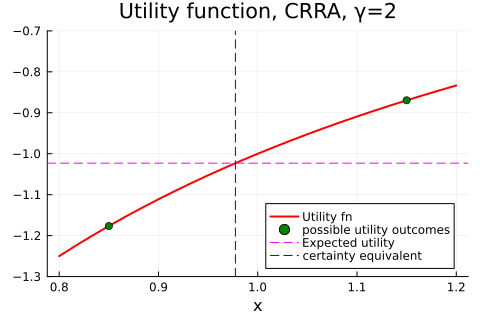

In [8]:
EU_i = E([π₁,π₂],U.([x₁,x₂],γ))  #expected utility
P    = U_1(EU_i,γ)               #certainty equivalent (inverting the utility fn)

p1 = plot( x_range,U.(x_range,γ),
           linecolor = :red,
           linewidth = 2,
           label = "Utility fn",
           ylim = (-1.3,-0.7),
           legend = :bottomright,
           title = "Utility function, CRRA, γ=$γ",
           xlabel = "x" )
scatter!([x₁,x₂],U.([x₁,x₂],γ),markercolor=:green,label="possible utility outcomes")
hline!([ExpUtil],linecolor=:magenta,line=(:dash,1),label="Expected utility")
vline!([P],linecolor=:blue,line=(:dash,1),label="certainty equivalent")
display(p1)

In [9]:
γM = [0,2,5,10,25,50,100]               #different risk aversions
L  = length(γM)

(P,ERx) = (fill(NaN,L),fill(NaN,L))
for i in 1:L                             #loop over γ values
    #local EU_i                           #local/global is needed in script
    EU_i   = E([π₁,π₂],U.([x₁,x₂],γM[i]))    #expected utility with γM[i]
    P[i]   = U_1(EU_i,γM[i])               #inverting the utility fn
    ERx[i] = Ex/P[i] - 1                   #required expected net return
end

printblue("risk aversion and certainly equivalent (recall: E(wealth) = $Ex):\n")
printmat(γM,P,ERx;colNames= ["γ","certainty eq","expected return"],width=20)

risk aversion and certainly equivalent (recall: E(wealth) = 1.0):

                   γ        certainty eq     expected return
               0                   1.000               0.000
               2                   0.977               0.023
               5                   0.947               0.056
              10                   0.912               0.097
              25                   0.875               0.143
              50                   0.862               0.160
             100                   0.856               0.168



# Utility-Based Portfolio Choice with One Risky Asset

In the example below, the investor maximizes $\text{E}\ln (1+R_{p})\text{, with }R_{p}=vR^e + R_{f}$ by choosing $v$ (the weight on the only risky asset). For simplicity, there are only two possible outcomes for $R^e$ with equal probabilities.

This particular problem can be solved by pen and paper, but this becomes very difficult when the number of states increases - and even worse when there are many assets. To prepare for these tricker cases, we apply a numerical optimization algorithm already to this simple problem.

### Remark on the Code

To solve the optimization problem we use `optimize()` from the [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl) package. The key steps are:

1. Define a function for expected utility, `EUlog(v,π,Rᵉ,Rf)`. The value depends on the portfolio choice `v`, as well as the properties of the asset (probabilities and returns for different states, the vectors `π` and `Rᵉ`) and the riskfree return (`Rf`).

2. To create data for the plot, we loop over `v[i]` values and calculate expected utility as `EUlog(v[i],π,Rᵉ,Rf)`. (Warning: you can assign a value to `π` provided you have not used the built-in constant `π` (3.14156...) first.)

3. For the optimization, we minimize the anonymous function `v->-EUlog(v,π,Rᵉ,Rf)`. This is a function of `v` only and we multiply by -1 since `optimize()` is a *minimization* routine.

In [10]:
"""
    EUlog(v,π,Rᵉ,Rf)

Calculate expected utility (log(1+Rp)) from investing into one risky and one riskfree asset

v:  scalar
π:  S vector probabilities of the different states
Rᵉ: S vector, excess returns of the risky asset in different states
Rf: scalar, riskfree rate

"""
function EUlog(v,π,Rᵉ,Rf)         #expected utility, utility fn is logarithmic
    Rₚ = v*Rᵉ .+ Rf               #portfolio return
    eu = E(π,log.(1 .+ Rₚ))       #expected utility
    return eu
end

EUlog

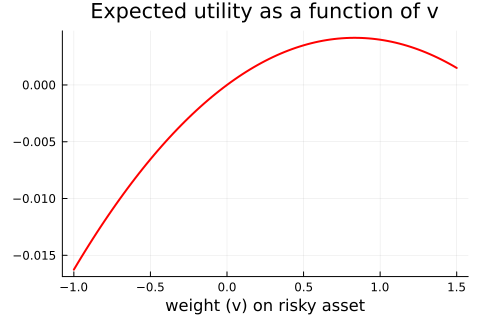

In [11]:
π  = [0.5,0.5]                 #probabilities for different states
Rᵉ = [-0.10,0.12]              #excess returns in different states
Rf = 0                         #riskfree rate

v_range = range(-1,1.5,length=101)    #try different weights on risky asset
L       = length(v_range)
EUv = fill(NaN,L)
for i in 1:L                                 #loop over v values
    EUv[i] = EUlog(v_range[i],π,Rᵉ,Rf)
end

p1 = plot( v_range,EUv,
           linecolor = :red,
           linewidth = 2,
           legend = false,
           title = "Expected utility as a function of v",
           xlabel = "weight (v) on risky asset" )
display(p1)

In [12]:
Sol = optimize(v->-EUlog(v,π,Rᵉ,Rf),-1,1)  #minimize -EUlog
printlnPs("Optimum at: ",Optim.minimizer(Sol))

printred("\nCompare with the figure")

Optimum at:      0.833

Compare with the figure


# Portfolio Choice with Several Risky Assets

This optimization problem has several risky assets and states and a CRRA utility function. Numerical optimization is still straightforward.

### A Remark on the Code

- The code below is fairly similar to the log utility case solved before, but extended to handle CRRA utility and several assets and states.
- With several choice variables, the call to `optimize()` requires a vector of starting guesses as input.

In [13]:
"""
    EUcrra(v,π,Rᵉ,Rf,γ)

Calculate expected utility from investing into n risky assets and one riskfree asset

v:  n vector (weights on the n risky assets)
π:  S vector (S possible "states")
Rᵉ: nxS matrix, each column is the n vector of excess returns in one of the states
Rf: scalar, riskfree rate
γ:  scalar, risk aversion
"""
function EUcrra(v,π,Rᵉ,Rf,γ)
    S  = length(π)
    Rp = fill(NaN,S)
    for s in 1:S           #loop over states, Rp in state s
        Rp[s] = v'Rᵉ[:,s] + Rf
    end                      #same as Rp = Rᵉ'v .+ Rf
    eu = E(π,U.(1 .+ Rp,γ))  #expected utility when using portfolio v
    return eu
end

EUcrra

In [14]:
R  = [-0.03 0.08 0.20;           #2 assets, 3 states
      -0.04 0.22 0.15]           #R[i,j] is the return of asset i in state j
π = [1/3,1/3,1/3]                #probs of the states
Rf = 0.065
Rᵉ = R .- Rf                     #excess returns in different states
γ  = 5

Sol = optimize(v->-EUcrra(v,π,Rᵉ,Rf,γ),[-0.6,1.2])     #minimize -EUcrra
v   = Optim.minimizer(Sol)                             #extract the solution

printblue("optimal portfolio weights from max EUcrra():\n")
printmat([v;1-sum(v)];rowNames=["asset 1","asset 2","riskfree"])

optimal portfolio weights from max EUcrra():

asset 1     -0.726
asset 2      1.317
riskfree     0.409



# Mean-Variance and the Telser Criterion

Let $\mu$ be a vector of expected returns of the investible assets and $\Sigma$ be their covariance matrix.

The Telser criterion solves a problem of the following type:

$\max_{v} \text{E}R_{p} \: \text{ subject to} \:  \text{VaR}_{95\%} < 0.1$,
where $\text{E}R_{p} =v'\mu^e+R_f$.

If the returns are normally distributed then 

$\text{VaR}_{95\%} = -[\text{E}R_{p} - 1.64\text{Std}(R_p)]$,

It follows that the VaR restriction can be written 

$\text{E}R_{p} > -0.1 + 1.64\text{Std}(R_p)$.

The figure below illustrates that the optimal portfolio is *on the CML* when the returns are normally distributed.

In [15]:
include("src/MvCalculations.jl");    #functions for traditional MV frontiers

In [16]:
μ = [9, 6]/100                       #mean returns of investable assets
Σ = [ 256    0;                      #covariance matrix
        0  144]/10000
Rf = 1/100

μˣ_range = range(Rf,0.1,length=101)      #required average returns
L        = length(μˣ_range)

(σMVF,σCML) = (fill(NaN,L),fill(NaN,L))
for i in 1:L                                      #loop over different required returns (μˣ)
    σMVF[i] = MVCalc(μˣ_range[i],μ,Σ)[1]          #std of MVF (risky only) at μˣ
    σCML[i] = MVCalcRf(μˣ_range[i],μ,Σ,Rf)[1]     #std of MVF (risky&riskfree) at μˣ
end

VaRRestr = -0.1 .+ 1.64*σCML;    #the portfolio mean return must be above this

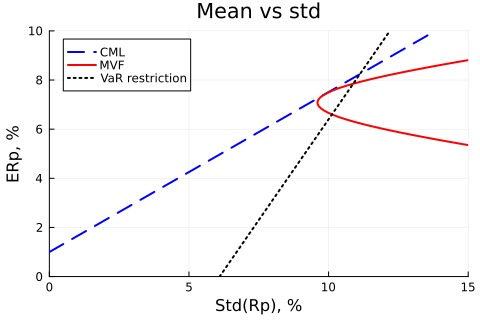

In [17]:
p1 = plot( [σCML σMVF σCML]*100,[μˣ_range μˣ_range VaRRestr]*100,
           linestyle = [:dash :solid :dot],
           linecolor = [:blue :red :black],
           linewidth = 2,
           label = ["CML" "MVF" "VaR restriction"],
           xlim = (0,15),
           ylim = (0,10),
           legend = :topleft,
           title = "Mean vs std",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
display(p1)